# Notebook 4: Solving the SIR Model

In this notebook, we will expand our previous workflow in order to solve the SIR Model. This model is the basic building block of most mathematical models of infectious diseases, and has a dynamic that is much more interesting than the simple SI model, in which people can only get infected or remain susceptible. In the SIR model, populations are divided into three groups: susceptibles to disease, infected undergoing infection and recovered. Recovered individuals already acquired the infection and thus became immunity for the rest of their lifespan. 

Using $S$, $I$ and $R$ to denote the proportions of individuals that are susceptible, infected and recovered in a population, the SIR model is defined by the following three equations:

\begin{aligned}
\frac{dS}{dt} = - \beta S I \\ 
\frac{dI}{dt} = \beta S I - \gamma I \\
\frac{dR}{dt} = \gamma I,
\end{aligned}
where $\beta$ is the disease transmissibility and $\gamma$ is its recovery rate. With these two parameters, we can calculate the basic reproductive ratio as $\mathcal{R_0} = \beta/\gamma$. 

## Importing packages and functions

In [10]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.optim as optim
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from neuralnet import NNetwork
torch.manual_seed(1234) 

## Solving the SIR Model

Different from the SI model, the SIR model has no analytical solution. Therefore, we will solve it numerically using the <code>odeint</code> module from the <code>scipy</code> package. Therefore, we first define a function of SIR derivatives:

In [3]:
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta*S*I
    dIdt = beta*S*I - gamma*I
    dRdt = gamma*I
    dydt = [dSdt, dIdt, dRdt]
    return dydt

Then, we define initial conditions, model parameters and we solve this equation in order to obtain the proportions of susceptibles, infected and recovered over time. 

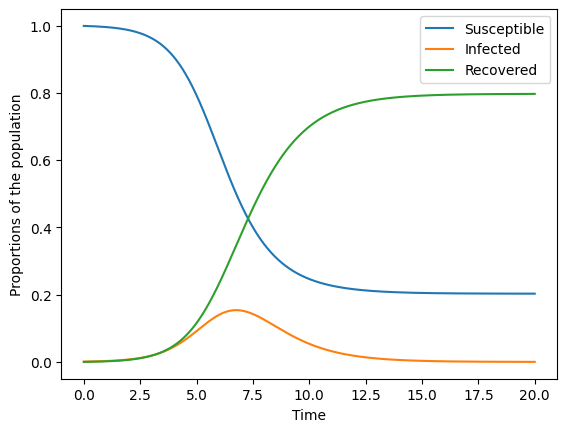

In [4]:
y0 = [0.999, 0.001, 0]
t = np.linspace(0, 20, 1000)
beta = 2
gamma = 1
sol = odeint(SIR_model, y0, t, args=(beta, gamma))
St = sol[:, 0]
It = sol[:, 1]
Rt = sol[:, 2]

plt.plot(t, St, label = 'Susceptible')
plt.plot(t, It, label = 'Infected')
plt.plot(t, Rt, label = 'Recovered')
plt.xlabel('Time')
plt.ylabel('Proportions of the population')
plt.legend()
plt.show()

## PINN loss function

Our main goal now will be to obtain the solution to this equation by training a PINN with an adequate loss. We will just simply generalise the loss that we were using for the SI model. By defining $\overline{y}$ to be $\overline{y(t)} = (S(t), I(t), R(t))$, we can calculate the data loss as:

\begin{aligned}
\mathcal{L_{\mathrm{data}}} = \sum_t \Big(\widehat{\overline{y(t)}} - \overline{y(t)}\Big)^2,
\end{aligned}
where $\widehat{\overline{y(t)}}$ corresponds to PINN predictions for the proportions of susceptible, infected and recovered.

Similarly, by defining the initial condition as $y(t = 0) = y_0 = (S(0), I(0), R(0))$, the boundary loss is computed as:
\begin{aligned}
\mathcal{L_{\mathrm{boundary}}} = \sum_t \Big(\widehat{\overline{y(t = 0)}} - \overline{y_0}\Big)^2.
\end{aligned}

Finally, the physics loss is generalized to be:

\begin{aligned}
\mathcal{L_{\mathrm{physics}}} = \mathcal{L_\mathrm{S}} + \mathcal{L_\mathrm{I}} + \mathcal{L_\mathrm{R}}, 
\end{aligned}

where the three terms each correspond to an equation for a state variable:

\begin{aligned}
\mathcal{L_\mathrm{S}} = \sum_{t_\mathrm{col}} \Bigg(\widehat{\frac{dS}{dt} (t_\mathrm{col})} + \beta \widehat{S(t_\mathrm{col})} \widehat{I(t_\mathrm{col})} \Bigg)^{2} \\
\mathcal{L_\mathrm{I}} = \sum_{t_\mathrm{col}} \Bigg(\widehat{\frac{dI}{dt} (t_\mathrm{col})} - \beta \widehat{S(t_\mathrm{col})} \widehat{I(t_\mathrm{col})} + \gamma \widehat{I(t_\mathrm{col})} \Bigg)^{2} \\
\mathcal{L_\mathrm{R}} = \sum_{t_\mathrm{col}} \Bigg(\widehat{\frac{dR}{dt} (t_\mathrm{col})} - \gamma \widehat{I(t_\mathrm{col})} \Bigg)^{2},
\end{aligned}
where each of these terms is calculated using collocation points $t_{col}$, as defined before.

## Defining tensors and data for training

### Collocation points

In [5]:
t_col = np.linspace(0, 20, 20)
t_col = torch.tensor(t_col, dtype = torch.float32).view(-1, 1).requires_grad_(True)

### Training data

In [7]:
t_data = torch.tensor(t[0:250], dtype = torch.float32).view(-1, 1).requires_grad_(True)
S_data = torch.tensor(St[0:250], dtype = torch.float32).view(-1, 1)
I_data = torch.tensor(It[0:250], dtype = torch.float32).view(-1, 1)
R_data = torch.tensor(Rt[0:250], dtype = torch.float32).view(-1, 1)
y_data = torch.cat((S_data, I_data, R_data), dim=1)

### Initial Conditions

In [6]:
t_initial = torch.tensor([0.0], dtype=torch.float32).view(-1, 1)
y_initial = torch.tensor(y0, dtype = torch.float32)

## Defining model and optimizer

In [12]:
model = NNetwork(1, 3, 64, 4)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

## Training the network

We train the network as always, for a greater number of epochs in this case. When writing the loss, it is important to take into account:
- We ask for derivatives three times, one for each state variable, as pytorch does not return multidimensional derivatives.
- It is very important to conduct a few checks along the way to be sure that the correct tensor dimensions are used when computing the loss. Usually, even if there is an error, pytorch will conduct broadcasting to, for example, substract two tensors. 

In [13]:
n_epochs = 20000 # epochs to train for
loss_epochs = []

for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    y_col = model(t_col)
    y_pred = model(t_data)
    y_pred_initial = model(t_initial)
    
    # ODE Loss
    S_pred = y_col[:, 0].view(-1, 1)
    I_pred = y_col[:, 1].view(-1, 1)
    R_pred = y_col[:, 2].view(-1, 1)
    dSdt = torch.autograd.grad(S_pred, t_col, torch.ones_like(S_pred), create_graph=True)[0]
    dIdt = torch.autograd.grad(I_pred, t_col, torch.ones_like(I_pred), create_graph=True)[0]
    dRdt = torch.autograd.grad(R_pred, t_col, torch.ones_like(R_pred), create_graph=True)[0]
    loss_ode_1 = dSdt + beta*S_pred*I_pred 
    loss_ode_2 = dIdt - beta*S_pred*I_pred + gamma*I_pred
    loss_ode_3 = dRdt - gamma*I_pred
    loss_ode = torch.mean(loss_ode_1**2 + loss_ode_2**2 + loss_ode_3**2)
    
    # Boundary condition loss
    loss_boundary = torch.mean((y_pred_initial - y_initial)**2)
    
    # Data loss
    loss_data = torch.mean((y_pred - y_data)**2)
    
    loss = loss_ode + loss_boundary + loss_data 
    loss_epochs.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        #print(f"Epoch {epoch}, Loss ODE: {loss_ode.item():.6f}")
        #print(f"Epoch {epoch}, Loss Boundary: {loss_boundary.item():.6f}")
        #print(f"Epoch {epoch}, Loss Data: {loss_data.item():.6f}")



Epoch 0, Loss: 0.609059
Epoch 1000, Loss: 0.000427
Epoch 2000, Loss: 0.000262
Epoch 3000, Loss: 0.000237
Epoch 4000, Loss: 0.000208
Epoch 5000, Loss: 0.000141
Epoch 6000, Loss: 0.000092
Epoch 7000, Loss: 0.000060
Epoch 8000, Loss: 0.000038
Epoch 9000, Loss: 0.000025
Epoch 10000, Loss: 0.000014
Epoch 11000, Loss: 0.000008
Epoch 12000, Loss: 0.000005
Epoch 13000, Loss: 0.000004
Epoch 14000, Loss: 0.000004
Epoch 15000, Loss: 0.000002
Epoch 16000, Loss: 0.000002
Epoch 17000, Loss: 0.000002
Epoch 18000, Loss: 0.000001
Epoch 19000, Loss: 0.000001


We now plot the loss over epochs, as always.

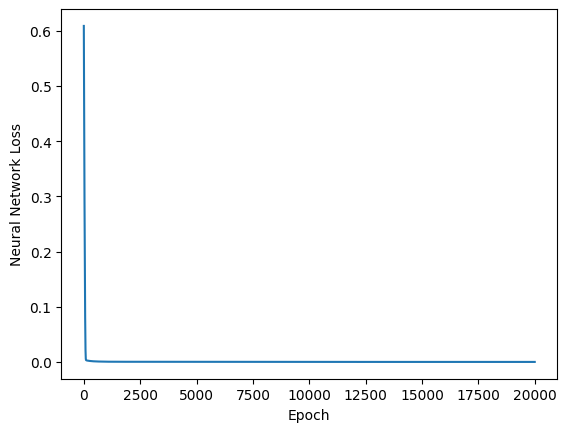

In [14]:
plt.plot(loss_epochs)
plt.xlabel('Epoch')
plt.ylabel('Neural Network Loss')
plt.show()

## Plotting results

Finally, we plot the dynamics of $S$, $I$ and $R$ over time, along with the PINN approximations.

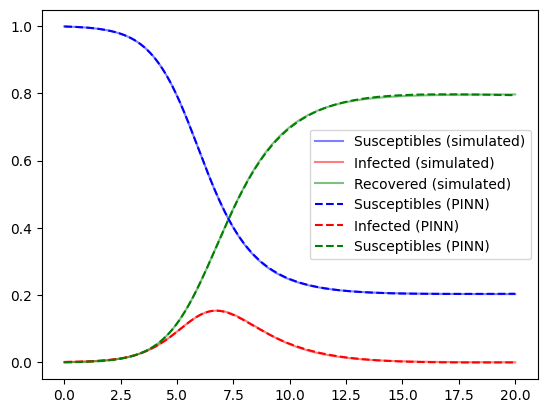

In [15]:
t_res = torch.tensor(t, dtype = torch.float32).view(-1, 1)
y_res = model(t_res)
S_res = y_res[:, 0].detach().cpu().numpy()
I_res = y_res[:, 1].detach().cpu().numpy()
R_res = y_res[:, 2].detach().cpu().numpy()


plt.plot(t, St, color = 'blue', label = 'Susceptibles (simulated)', alpha = 0.5)
plt.plot(t, It, color = 'red', label = 'Infected (simulated)', alpha = 0.5)
plt.plot(t, Rt, color = 'green', label = 'Recovered (simulated)', alpha = 0.5)
plt.plot(t_res, S_res, color = 'blue', linestyle = '--', label = 'Susceptibles (PINN)')
plt.plot(t_res, I_res, color = 'red', linestyle = '--', label = 'Infected (PINN)')
plt.plot(t_res, R_res, color = 'green',  linestyle = '--', label = 'Susceptibles (PINN)')
plt.legend()
plt.show()    